In [1]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_employee = pd.read_csv('Employee.csv')
data_employee.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


# Data Splitting

In [3]:
# prepare feature (X) and label (y) 
X = data_employee.drop('LeaveOrNot', axis=1)
y = data_employee['LeaveOrNot']

In [4]:
# splitting data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.25,
                                                   random_state=42,
                                                   stratify=y)

In [5]:
# check volume data
X_train.shape, y_train.shape

((3489, 8), (3489,))

# EDA

In [6]:
# merge data train for EDA
data_vis = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
data_vis

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
2250,Bachelors,2012,New Delhi,3,30,Male,No,1,0
425,PHD,2018,New Delhi,3,25,Male,No,3,1
4182,Masters,2017,Pune,2,24,Male,No,2,0
1105,Bachelors,2018,Bangalore,3,25,Female,Yes,3,1
3033,Bachelors,2017,New Delhi,2,41,Female,No,3,0
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4431,Bachelors,2016,Pune,2,29,Female,No,4,1
1847,Bachelors,2016,Bangalore,3,26,Male,Yes,4,0
2148,Bachelors,2014,Bangalore,3,26,Male,No,4,0


In [7]:
# missing value check
data_vis.isna().mean()

Education                    0.0
JoiningYear                  0.0
City                         0.0
PaymentTier                  0.0
Age                          0.0
Gender                       0.0
EverBenched                  0.0
ExperienceInCurrentDomain    0.0
LeaveOrNot                   0.0
dtype: float64

In [8]:
# duplicate rows check
data_vis.duplicated().sum()

1274

In [9]:
# drop duplcate rows
data_vis.drop_duplicates(inplace=True)

<Axes: xlabel='LeaveOrNot', ylabel='count'>

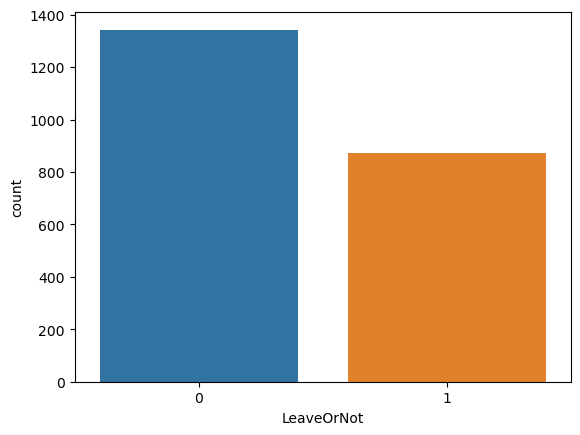

In [10]:
# proportion label train
sns.countplot(x='LeaveOrNot', data=data_vis)

In [11]:
# unique value each colum
for c in X_train.columns[:-1]:
    nv = X_train[c].nunique()
    print(f'{c} : ', nv)
    print()

Education :  3

JoiningYear :  7

City :  3

PaymentTier :  3

Age :  20

Gender :  2

EverBenched :  2



In [12]:
# sort out
categori = ['Education', 'City', 'PaymentTier', 'Gender', 'EverBenched']
numeric = ['JoiningYear', 'Age', 'ExperienceInCurrentDomain']

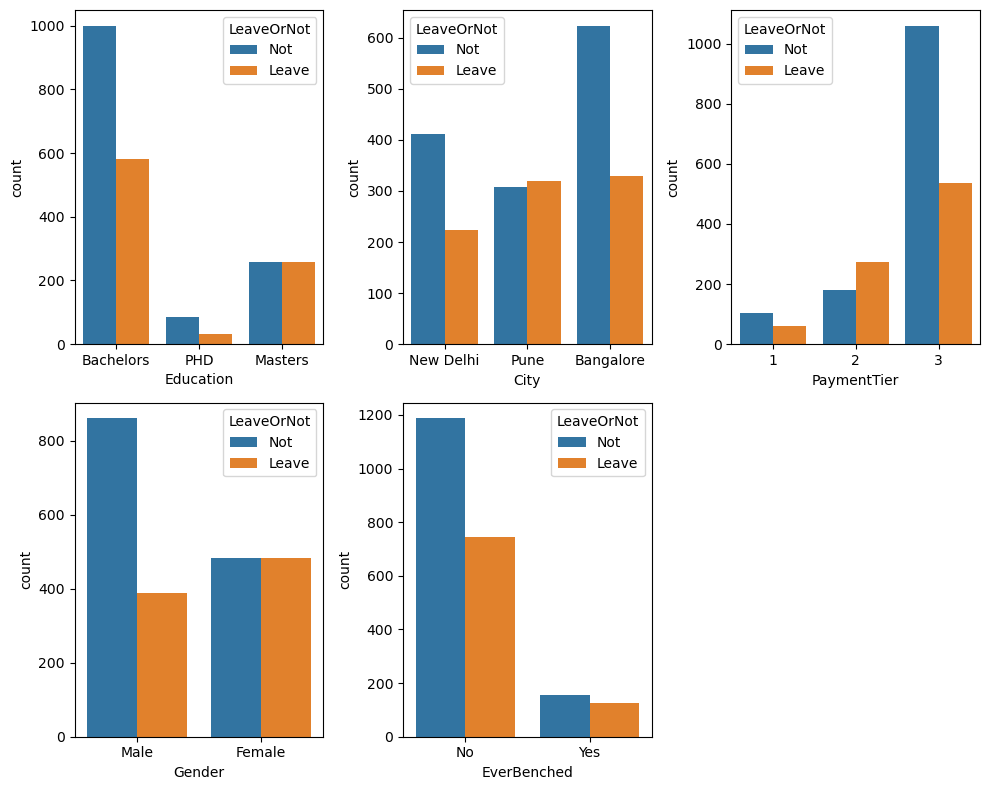

In [13]:
# visualization data categorical

# change labels
for_vis = data_vis.copy(deep=True)
for_vis['LeaveOrNot'] = for_vis['LeaveOrNot'].map(lambda x: 'Leave' if x == 1 else 'Not')

# plotting
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,8))
ax = ax.flatten()

for a,c in zip(ax,categori):
    sns.countplot(x=c, data=for_vis, hue='LeaveOrNot', ax=a)
    
ax[5].remove()
plt.tight_layout()
plt.show()

In [14]:
# numeric
correlation = data_vis.select_dtypes(include='number').corr()['LeaveOrNot'].sort_values(ascending=False)
print(correlation)

LeaveOrNot                   1.000000
JoiningYear                  0.170373
ExperienceInCurrentDomain    0.009290
Age                         -0.121712
PaymentTier                 -0.131396
Name: LeaveOrNot, dtype: float64


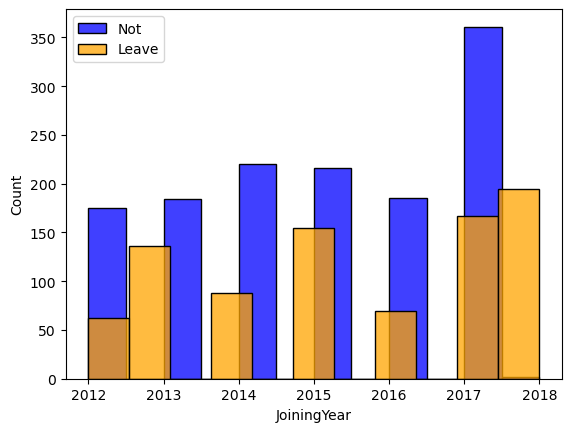

In [15]:
# visualisasi joining year
plt.figure()
sns.histplot(x='JoiningYear', data=data_vis[data_vis['LeaveOrNot']==0],color='b', label='Not')
sns.histplot(x='JoiningYear', data=data_vis[data_vis['LeaveOrNot']==1], color='orange', label='Leave')
plt.legend()
plt.show()

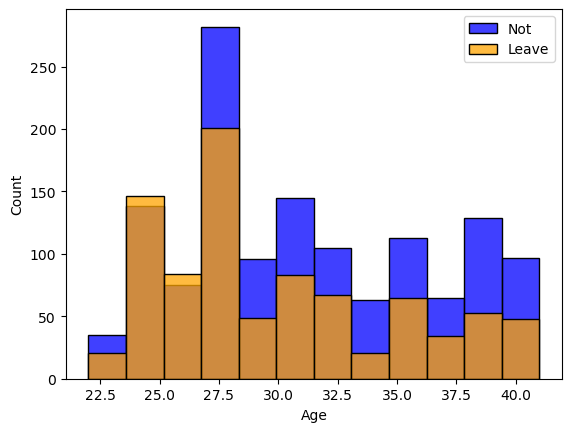

In [16]:
# visualisasi Age
plt.figure()
sns.histplot(x='Age', data=data_vis[data_vis['LeaveOrNot']==0],color='b', label='Not')
sns.histplot(x='Age', data=data_vis[data_vis['LeaveOrNot']==1], color='orange', label='Leave')
plt.legend()
plt.show()

In [17]:
data_vis[data_vis['JoiningYear']==2018]['LeaveOrNot'].value_counts(normalize=True)

LeaveOrNot
1    0.989848
0    0.010152
Name: proportion, dtype: float64

### join in 2018 is very influental for prediction
#### maybe this insigh can usedull for prediction

In [18]:
data_vis[(data_vis['Age']>23) & (data_vis['Age']<26)]['LeaveOrNot'].value_counts(normalize=True)

LeaveOrNot
1    0.514085
0    0.485915
Name: proportion, dtype: float64

### and i have idea for bining Age colum for modelling
#### maybe with it can be improve my model better than previously

# Feature Engineering

In [19]:
# split feature and labels
X_train = data_vis.drop('LeaveOrNot', axis=1)
y_train = data_vis['LeaveOrNot']
X_train.shape, y_train.shape

((2215, 8), (2215,))

In [20]:
# import library for pipline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

In [21]:
X_train

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
2250,Bachelors,2012,New Delhi,3,30,Male,No,1
425,PHD,2018,New Delhi,3,25,Male,No,3
4182,Masters,2017,Pune,2,24,Male,No,2
1105,Bachelors,2018,Bangalore,3,25,Female,Yes,3
3033,Bachelors,2017,New Delhi,2,41,Female,No,3
...,...,...,...,...,...,...,...,...
3843,Bachelors,2016,Pune,3,36,Male,No,0
2475,Bachelors,2014,Bangalore,1,28,Male,No,1
3676,Bachelors,2012,Pune,3,31,Male,No,3
3824,Bachelors,2016,New Delhi,3,37,Male,No,3


In [22]:
# step 1 (impute data)

# convert to dataframe
def ToDataFrame(D):
    df = pd.DataFrame(D, columns=['JoiningYear', 'Age', 'ExperienceInCurrentDomain', 
                                  'Education', 'City', 'PaymentTier', 'Gender', 'EverBenched'])
    return df

# impute data
impute  = ColumnTransformer([
    ('imp_mean', SimpleImputer(strategy='mean'), numeric),
    ('imp_mode', SimpleImputer(strategy='most_frequent'), categori)
])

# make pipeline for step 1
step1 = Pipeline([
    ('imp', impute),
    ('to_df', FunctionTransformer(ToDataFrame))
])

In [23]:
# step 2 (bining and adding data)

# make function to adding data who join in 2018
def JoinIn2018(DATA):
    # make blank list for new_values
    D = DATA.copy(deep=True)
    new_values = []
    
    # looping data for filltering
    for d in D['JoiningYear']:
        if d == 2018:
            new_values.append(1)
        else:
            new_values.append(0)
    
    # adding to dataframe
    col_index = D.columns.tolist().index('JoiningYear')+1
    D.insert(col_index, 'JoinIn2018', new_values)
    return D

# make function to bining data age
def BiningAge(D):
    bining_age = pd.cut(D['Age'],
                        bins=[0, 27, 35, 45],
                        labels=[1,2,3])
    col_index = D.columns.tolist().index('Age')+1
    D.insert(col_index, 'BiningAge', bining_age)
    return D

# make Pipeline for step 2
step2 = Pipeline([
    ('adding', FunctionTransformer(JoinIn2018)),
    ('bining', FunctionTransformer(BiningAge))
])

In [24]:
# step 3 (convert object to numeric / encoding)

# import library (encoder)
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# make function to encode Education by order
def EncodeEducation(D):
    # make blank list for new values
    new_values = []
    
    # looping for encode data
    for d  in D['Education']:
        if d == 'Bachelors':
            new_values.append(0)
        elif d == 'Masters':
            new_values.append(1)
        elif d == 'PHD':
            new_values.append(2)
        else:
            raise('There is foreign value')
    
    # change data value with new values
    D['Education'] = new_values
    return D

# make pipeline for step 3
step3 = ColumnTransformer([
    ('enc_edu', FunctionTransformer(EncodeEducation), ['Education']),
    ('oe', OrdinalEncoder(),['Gender', 'EverBenched']),
    ('ohe', OneHotEncoder(),['City'])
],remainder='passthrough')

In [25]:
# pipeline before scaling
before_scaling = Pipeline([
    ('step1', step1),
    ('step2', step2),
    ('step3', step3)
])

# fitting pipeline
before_scaling.fit(X_train)

Pipeline(steps=[('step1',
                 Pipeline(steps=[('imp',
                                  ColumnTransformer(transformers=[('imp_mean',
                                                                   SimpleImputer(),
                                                                   ['JoiningYear',
                                                                    'Age',
                                                                    'ExperienceInCurrentDomain']),
                                                                  ('imp_mode',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['Education',
                                                                    'City',
                                                                    'PaymentTier',
                                                                    'Gender',
                                                                    'EverBenched'])])),
                                 ('to_df',
                                  FunctionTransformer(func=<function ToDataFrame at 0x000001B7477B60C0>))...
                                  FunctionTransformer(func=<function JoinIn2018 at 0x000001B7477B62A0>)),
                                 ('bining',
                                  FunctionTransformer(func=<function BiningAge at 0x000001B7477B65C0>))])),
                ('step3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enc_edu',
                                                  FunctionTransformer(func=<function EncodeEducation at 0x000001B7477B6200>),
                                                  ['Education']),
                                                 ('oe', OrdinalEncoder(),
                                                  ['Gender', 'EverBenched']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['City'])]))])

In [26]:
# check
check = before_scaling.transform(X_train)
check

array([[0, 1.0, 0.0, ..., 2, 1.0, 3],
       [2, 1.0, 0.0, ..., 1, 3.0, 3],
       [1, 1.0, 0.0, ..., 1, 2.0, 2],
       ...,
       [0, 1.0, 0.0, ..., 2, 3.0, 3],
       [0, 1.0, 0.0, ..., 3, 3.0, 3],
       [0, 0.0, 0.0, ..., 2, 4.0, 2]], dtype=object)

In [27]:
# scalling

# import library (scaler)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

# make pipeline for step 4
def scaling(D, scale=StandardScaler()):
    D_scaling = scale.fit_transform(D)
    return D_scaling

In [28]:
# procesing pipeline
processing_pipeline = Pipeline([
    ('before_scale', before_scaling),
    ('scale', FunctionTransformer(scaling))
])
processing_pipeline.fit(X_train)

Pipeline(steps=[('before_scale',
                 Pipeline(steps=[('step1',
                                  Pipeline(steps=[('imp',
                                                   ColumnTransformer(transformers=[('imp_mean',
                                                                                    SimpleImputer(),
                                                                                    ['JoiningYear',
                                                                                     'Age',
                                                                                     'ExperienceInCurrentDomain']),
                                                                                   ('imp_mode',
                                                                                    SimpleImputer(strategy='most_frequent'),
                                                                                    ['Education',
                                                                                     'City',
                                                                                     'PaymentTier',
                                                                                     'Gender',
                                                                                     'EverBenched'])])),
                                                  ('to_df',
                                                   FunctionTransformer(func=<function To...
                                                   FunctionTransformer(func=<function BiningAge at 0x000001B7477B65C0>))])),
                                 ('step3',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('enc_edu',
                                                                   FunctionTransformer(func=<function EncodeEducation at 0x000001B7477B6200>),
                                                                   ['Education']),
                                                                  ('oe',
                                                                   OrdinalEncoder(),
                                                                   ['Gender',
                                                                    'EverBenched']),
                                                                  ('ohe',
                                                                   OneHotEncoder(),
                                                                   ['City'])]))])),
                ('scale',
                 FunctionTransformer(func=<function scaling at 0x000001B7477B7CE0>))])

In [29]:
# check pipeline
X_train_processed = processing_pipeline.transform(X_train)
X_train_processed

array([[-0.59029597,  0.87944229, -0.38195186, ...,  0.10142991,
        -1.05782027,  0.57607616],
       [ 2.88711248,  0.87944229, -0.38195186, ..., -1.26018981,
         0.1938207 ,  0.57607616],
       [ 1.14840825,  0.87944229, -0.38195186, ..., -1.26018981,
        -0.43199979, -1.05564852],
       ...,
       [-0.59029597,  0.87944229, -0.38195186, ...,  0.10142991,
         0.1938207 ,  0.57607616],
       [-0.59029597,  0.87944229, -0.38195186, ...,  1.46304963,
         0.1938207 ,  0.57607616],
       [-0.59029597, -1.13708428, -0.38195186, ...,  0.10142991,
         0.81964119, -1.05564852]])

# Modeling

In [30]:
# import object model

# param
param_grid = {'scl__kw_args' : [{'scale' : StandardScaler()}, 
                                {'scale' : MinMaxScaler()}, 
                                {'scale' : Normalizer(norm='l1')}, 
                                {'scale' : Normalizer(norm='l2')}],
              'algo__n_neighbors' : list(range(1,50,2)),
              'algo__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# algorithm
from sklearn.neighbors import KNeighborsClassifier

# pipeline model
my_pipeline = Pipeline([
    ('s1', step1),
    ('s2', step2),
    ('s3', step3),
    ('scl', FunctionTransformer(scaling)),
    ('algo', KNeighborsClassifier())
])
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('s1',
                 Pipeline(steps=[('imp',
                                  ColumnTransformer(transformers=[('imp_mean',
                                                                   SimpleImputer(),
                                                                   ['JoiningYear',
                                                                    'Age',
                                                                    'ExperienceInCurrentDomain']),
                                                                  ('imp_mode',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['Education',
                                                                    'City',
                                                                    'PaymentTier',
                                                                    'Gender',
                                                                    'EverBenched'])])),
                                 ('to_df',
                                  FunctionTransformer(func=<function ToDataFrame at 0x000001B7477B60C0>))]))...
                ('s3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enc_edu',
                                                  FunctionTransformer(func=<function EncodeEducation at 0x000001B7477B6200>),
                                                  ['Education']),
                                                 ('oe', OrdinalEncoder(),
                                                  ['Gender', 'EverBenched']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['City'])])),
                ('scl',
                 FunctionTransformer(func=<function scaling at 0x000001B7477B7CE0>)),
                ('algo', KNeighborsClassifier())])

In [31]:
# tuning model
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(my_pipeline, param_grid=param_grid, cv=4, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('s1',
                                        Pipeline(steps=[('imp',
                                                         ColumnTransformer(transformers=[('imp_mean',
                                                                                          SimpleImputer(),
                                                                                          ['JoiningYear',
                                                                                           'Age',
                                                                                           'ExperienceInCurrentDomain']),
                                                                                         ('imp_mode',
                                                                                          SimpleImputer(strategy='most_frequent'),
                                                                                          ['Education',
                                                                                           'City',
                                                                                           'PaymentTier',
                                                                                           'Gender',
                                                                                           'EverBenched'])])),
                                                        ('to_df',
                                                         FunctionTransformer(func=<function ToDataFra...
                                        FunctionTransformer(func=<function scaling at 0x000001B7477B7CE0>)),
                                       ('algo', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'algo__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                             'brute'],
                         'algo__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17,
                                               19, 21, 23, 25, 27, 29, 31, 33,
                                               35, 37, 39, 41, 43, 45, 47, 49],
                         'scl__kw_args': [{'scale': StandardScaler()},
                                          {'scale': MinMaxScaler()},
                                          {'scale': Normalizer(norm='l1')},
                                          {'scale': Normalizer()}]},
             verbose=1)

In [32]:
# best score
model.best_score_

0.775158962273389

In [33]:
# best estimator
model.best_estimator_

Pipeline(steps=[('s1',
                 Pipeline(steps=[('imp',
                                  ColumnTransformer(transformers=[('imp_mean',
                                                                   SimpleImputer(),
                                                                   ['JoiningYear',
                                                                    'Age',
                                                                    'ExperienceInCurrentDomain']),
                                                                  ('imp_mode',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['Education',
                                                                    'City',
                                                                    'PaymentTier',
                                                                    'Gender',
                                                                    'EverBenched'])])),
                                 ('to_df',
                                  FunctionTransformer(func=<function ToDataFrame at 0x000001B7477B60C0>))]))...
                                   transformers=[('enc_edu',
                                                  FunctionTransformer(func=<function EncodeEducation at 0x000001B7477B6200>),
                                                  ['Education']),
                                                 ('oe', OrdinalEncoder(),
                                                  ['Gender', 'EverBenched']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['City'])])),
                ('scl',
                 FunctionTransformer(func=<function scaling at 0x000001B7477B7CE0>,
                                     kw_args={'scale': StandardScaler()})),
                ('algo',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=11))])

In [34]:
# check model score
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.8049661399548532
0.8256013745704467


# Evaluasi Model

In [35]:
# data prediction
y_pred = model.predict(X_test)
y_pred[:5]

array([0, 0, 0, 0, 0], dtype=int64)

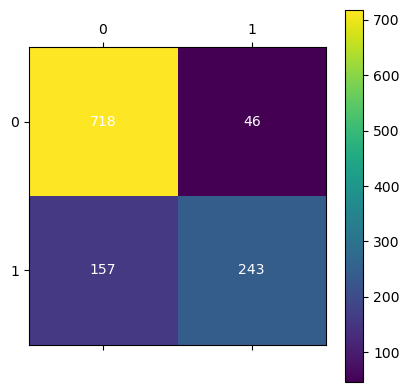

In [36]:
# report
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = matrix.ravel()

#visualization
import matplotlib.pyplot as plt
plt.matshow(matrix)

for (i, j), value in np.ndenumerate(matrix):
    plt.text(j, i, f'{value}', ha='center', va='center', color='white')

plt.colorbar()

# Save Model & Pipeline

In [37]:
# save model 
import pickle
pickle.dump(model.best_estimator_, open('model/knn2.pkl', 'wb'))

In [40]:
pickle.dump((tn,fp,fn,tp), open('eval/eval_knn2.pkl','wb'))

In [38]:
pickle.dump(my_pipeline, open('model/pipeline.pkl','wb'))